In [24]:
from celcomen.models.celcomen import celcomen
from celcomen.models.simcomen import simcomen
from celcomen.utils.helpers import normalize_g2g, calc_sphex, calc_gex

In [25]:
!pwd

/nfs/team205/sm58/packages/celcomen_trials/celcomen_final


In [26]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [109]:
from torch_geometric.loader import DataLoader
import scanpy as sc
import torch
import torch_geometric
from sklearn.neighbors import kneighbors_graph

def get_dataset_loaders(h5ad_path: str, sample_id_name: str, n_neighbors: int, verbose: bool):

    adata = sc.read_h5ad(h5ad_path) 

    sc.pp.filter_genes(adata, min_cells=5)
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata, flavor='seurat', n_top_genes=20000, subset=True)
    
    print(adata)

    adata_list = [  adata[adata.obs[sample_id_name]==i] for i in set(adata.obs[sample_id_name])  ]

    data_list = []
    n_neighbors = 6

    for adata in adata_list:
        pos = torch.from_numpy(adata.obsm["spatial"])
        x = torch.from_numpy(adata.X.todense())    # here x is nodes x 33500 -> add filteration here to take "best" 100
        # normalize x 
        norm_factor = torch.pow(x,2).sum(1).reshape(-1,1)
        x = torch.div(x, norm_factor)
        y = torch.Tensor([0])   # here we will store GT value
        #edge_index = knn_graph(pos, k=n_neighbors)
        edge_index = kneighbors_graph(pos, n_neighbors, include_self=False).todense()
        edge_index = torch.from_numpy(np.array(np.where(edge_index)))
        data = torch_geometric.data.Data(x=x, pos=pos, y=y, edge_index=edge_index)
        data.validate(raise_on_error=True)    # performs basic checks on the graph
        data_list.append(data)

    #data_list = data_list[:1]

    loader = DataLoader( data_list, batch_size=1, shuffle=True)

    if verbose:
        for step, data in enumerate(loader):
            print(f'Step {step+1}')
            print("=====")
            print(f'Number of graphs in the current batch: {data.num_graphs}')
            print(data)
            print()

    return loader

In [110]:
h5ad_path="data/visium-OCT_SAN_raw.h5ad"

loader = get_dataset_loaders("data/visium-OCT_SAN_raw.h5ad", "sangerID", 6, True, )

AnnData object with n_obs × n_vars = 27108 × 20000
    obs: 'in_tissue', 'array_row', 'array_col', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mt_frac', 'n_counts', 'n_genes', 'annotation_JC', 'sangerID', 'Publication', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'region_cell2loc'
    var: 'gene_ids', 'feature_types', 'genome', 'SYMBOL', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'spatial', 'log1p', 'hvg'
    obsm: 'MT', 'means_cell_abundance_w_sf', 'q05_cell_abundance_w_sf', 'q95_cell_abundance_w_sf', 'spatial', 'stds_cell_abundance_w_sf'
Step 1
=====
Number of graphs in the current batch: 1
DataBatch(x=[3448, 20000], edge_index=[2, 20688], y=[1], pos=[3448, 2], batch=[3448]

In [111]:
from tqdm import tqdm
import numpy as np
import torch
            
            
def train(num_epochs, learning_rate, model, loader, zmft_scalar=1e-1, seed=1, device="cpu"):
    
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0)
    losses = []
    model.train()
    torch.manual_seed(seed)
    
    for epoch in range(num_epochs):
        losses_= []

        for data in loader:
            # move data to device
            data = data.to(device)
            # train loader  # Iterate in batches over the training dataset.
            # set the appropriate gex
            model.set_gex(data.x)
            # derive the message as well as the mean field approximation
            msg, msg_intra, log_z_mft = model(data.edge_index, 1)
            # compute the loss and track it
            loss = -(-log_z_mft + zmft_scalar * torch.trace(torch.mm(msg, torch.t(model.gex))) + zmft_scalar * torch.trace(torch.mm(msg_intra, torch.t(model.gex))) )
            if device=="cpu":
                losses_.append(loss.detach().numpy()[0][0])
            else:
                losses_.append(loss.detach().cpu().numpy()[0][0])
            # derive the gradients, update, and clear
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            # repeatedly force a normalization
            model.conv1.lin.weight = torch.nn.Parameter(normalize_g2g(model.conv1.lin.weight), requires_grad=True)
            model.lin.weight = torch.nn.Parameter(normalize_g2g(model.lin.weight), requires_grad=True)
            optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0)
            
        print(f"Epoch={epoch}   |   Loss={np.mean(losses_)}")
        losses.append(np.mean(losses_))

    return losses


In [112]:
torch.cuda.is_available()

True

In [115]:
n_genes= 20000 #20715 #33
n_neighbors=6
seed=1
zmft_scalar = 0.01
epochs = 100
learning_rate = 5e-3


model = celcomen(input_dim=n_genes, output_dim=n_genes, n_neighbors=n_neighbors, seed=seed)
model.to("cuda")
losses = train(epochs, learning_rate, model, loader, zmft_scalar=zmft_scalar, seed=1, device="cuda")

Epoch=0   |   Loss=3006.8486328125
Epoch=1   |   Loss=3079.48095703125
Epoch=2   |   Loss=3010.28857421875
Epoch=3   |   Loss=2952.48388671875
Epoch=4   |   Loss=2903.593017578125
Epoch=5   |   Loss=2861.869140625
Epoch=6   |   Loss=2825.90478515625
Epoch=7   |   Loss=2794.681640625
Epoch=8   |   Loss=2767.325439453125
Epoch=9   |   Loss=2743.2021484375
Epoch=10   |   Loss=2721.763916015625
Epoch=11   |   Loss=2702.5732421875
Epoch=12   |   Loss=2685.2958984375
Epoch=13   |   Loss=2669.68017578125
Epoch=14   |   Loss=2655.48974609375
Epoch=15   |   Loss=2642.556640625
Epoch=16   |   Loss=2630.7138671875
Epoch=17   |   Loss=2619.834716796875
Epoch=18   |   Loss=2609.8037109375
Epoch=19   |   Loss=2600.5234375
Epoch=20   |   Loss=2591.91455078125
Epoch=21   |   Loss=2583.902587890625
Epoch=22   |   Loss=2576.42431640625
Epoch=23   |   Loss=2569.42333984375
Epoch=24   |   Loss=2562.858642578125
Epoch=25   |   Loss=2556.68505859375
Epoch=26   |   Loss=2550.86767578125
Epoch=27   |   Loss=2

[Text(0.5, 0, 'epochs'), Text(0, 0.5, 'loss')]

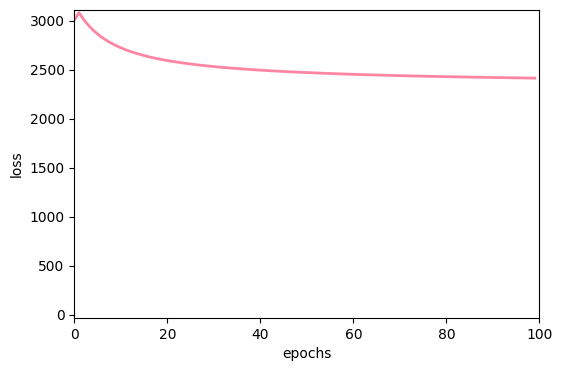

In [116]:
# create the plot
fig, ax = plt.subplots(figsize=[6, 4])
ax.grid(False)
ax.plot(losses, lw=2, color='#fe86a4')
ax.set_xlim(0, epochs)
vmin, vmax = min(min(losses), 0), max(losses)
vstep = (vmax - vmin) * 0.01
ax.set_ylim(vmin-vstep, vmax+vstep)
ax.set(xlabel='epochs', ylabel='loss')

In [ ]:
adata = sc.read_h5ad(h5ad_path) 
adata_list = [  adata[adata.obs[sample_id_name]==i] for i in set(adata.obs["sangerID"])  ]
adata_control = adata_list[0]

spot_id
HCAHeartST10659160_AAACAACGAATAGTTC-1    HCAHeartST10659160
HCAHeartST10659160_AAACAAGTATCTCCCA-1    HCAHeartST10659160
HCAHeartST10659160_AAACAATCTACTAGCA-1    HCAHeartST10659160
HCAHeartST10659160_AAACACCAATAACTGC-1    HCAHeartST10659160
HCAHeartST10659160_AAACAGAGCGACTCCT-1    HCAHeartST10659160
                                                ...        
HCAHeartST13233999_TTGTTCAGTGTGCTAC-1    HCAHeartST13233999
HCAHeartST13233999_TTGTTCTAGATACGCT-1    HCAHeartST13233999
HCAHeartST13233999_TTGTTGTGTGTCAAGA-1    HCAHeartST13233999
HCAHeartST13233999_TTGTTTCCATACAACT-1    HCAHeartST13233999
HCAHeartST13233999_TTGTTTGTGTAAATTC-1    HCAHeartST13233999
Name: sangerID, Length: 27108, dtype: category
Categories (8, object): ['HCAHeartST10659160', 'HCAHeartST12992072', 'HCAHeartST13228105', 'HCAHeartST13228106', 'HCAHeartST13233996', 'HCAHeartST13233997', 'HCAHeartST13233998', 'HCAHeartST13233999']

In [12]:
adata

AnnData object with n_obs × n_vars = 27108 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mt_frac', 'n_counts', 'n_genes', 'annotation_JC', 'sangerID', 'Publication', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'region_cell2loc'
    var: 'gene_ids', 'feature_types', 'genome', 'SYMBOL'
    uns: 'spatial'
    obsm: 'MT', 'means_cell_abundance_w_sf', 'q05_cell_abundance_w_sf', 'q95_cell_abundance_w_sf', 'spatial', 'stds_cell_abundance_w_sf'